In [11]:
from scipy.stats import linregress
import pandas as pd
import numpy as np
import data_gathering
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler


# Helper Function

In [ ]:
def normalize(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data

# Data Preprocessing

In [12]:
index = ["Atlanta city, Georgia", "Baltimore city, Maryland", "Boston city, Massachusetts", "Charlotte city, North Carolina",
         "Chicago city, Illinois", "Cleveland city, Ohio", "Denver city, Colorado", "Detroit city, Michigan",
         "Houston city, Texas", "Indianapolis city (balance), Indiana", "Las Vegas city, Nevada",
         "Los Angeles city, California", "Miami city, Florida", "Nashville-Davidson metropolitan government (balance), Tennessee",
         "New Orleans city, Louisiana", "New York city, New York", "Philadelphia city, Pennsylvania",
         "San Francisco city, California", "Seattle city, Washington", "Washington city, District of Columbia"]

cities = ['Atlanta, GA', 'Baltimore, MD', 'Boston, MA', 'Charlotte, NC', 'Chicago, IL', 'Cleveland, OH', 'Denver, CO', 'Detroit, MI', 'Houston, TX', 'Indianapolis, IN', 'Las Vegas, NV', 'Los Angeles, CA', 'Miami, FL', 'Nashville, TN', 'New Orleans, LA', 'New York, NY', 'Philadelphia, PA', 'San Francisco, CA', 'Seattle, WA', 'Washington, DC']

matching_dict = dict(zip(cities, index))
covid = data_gathering.get_covid_data()
covid = covid.loc[:, ['FIPS', 'city', 'time_value', 'value']].dropna()
covid_cities = dict(tuple(covid.groupby('city')))

dfs = []
for city in cities:
    city_covid = covid_cities[city]
    sentiment_data = next(data for data in data_gathering.get_sentiment_data())
    merged_data = pd.merge(sentiment_data[['index', 'mean','counts']], city_covid, left_on='index', right_on='time_value', how='inner')
    dfs.append(merged_data)
result = pd.concat(dfs)
result = result.reset_index(drop=True)

result['city'] = result['city'].map(matching_dict)
result = result.rename(columns={'mean': 'vader', 'value':'cases'})
result = result.drop('time_value',axis=1)
result['index'] = pd.to_datetime(result['index'])
result[['vader','counts','cases']] = result[['vader','counts','cases']].astype(float)

# Compute Weekly Averages

### Weewkly Averages by city

In [13]:
weighted_avg_vader_city = result.groupby([pd.Grouper(key='index', freq='W'), 'city']).apply(lambda x: (x['vader'] * x['counts']).sum() / x['counts'].sum())
avg_cases_city = result.groupby([pd.Grouper(key='index', freq='W'), 'city'])['cases'].mean()
weekly_averages_city = pd.DataFrame({'WEIGHTED_AVERAGE_VADER': weighted_avg_vader_city, 'AVERAGE_CASES': avg_cases_city}).reset_index()

print(weekly_averages_city)

            WEIGHTED_AVERAGE_VADER  AVERAGE_CASES
index                                            
2020-02-23                0.144178       0.000000
2020-03-01                0.150440       0.000402
2020-03-08                0.146475       0.019650
2020-03-15                0.123320       0.171140
2020-03-22                0.128173       2.012096
2020-03-29                0.128446       9.509539
2020-04-05                0.127316      21.563715
2020-04-12                0.131864      26.660657
2020-04-19                0.132359      20.948763
2020-04-26                0.148649      17.600025
2020-05-03                0.151914      15.160437
2020-05-10                0.149061      13.388717
2020-05-17                0.149794      10.610379
2020-05-24                0.144986      10.048673
2020-05-31                0.057829       9.318992
2020-06-07                0.063306       8.273820
2020-06-14                0.107986       7.417792
2020-06-21                0.109892       7.826898


### Weekly Averages by city

In [ ]:
weighted_avg_vader = result.groupby(pd.Grouper(key='index', freq='W')) \
    .apply(lambda x: sum(x['vader'] * x['counts']) / sum(x['counts']))
avg_cases = result.groupby(pd.Grouper(key='index', freq='W'))['cases'].mean()
weekly_averages = pd.DataFrame({
    'WEIGHTED_AVERAGE_VADER': weighted_avg_vader,
    'AVERAGE_CASES': avg_cases
})
print(weekly_averages)

# Plot weekly time series

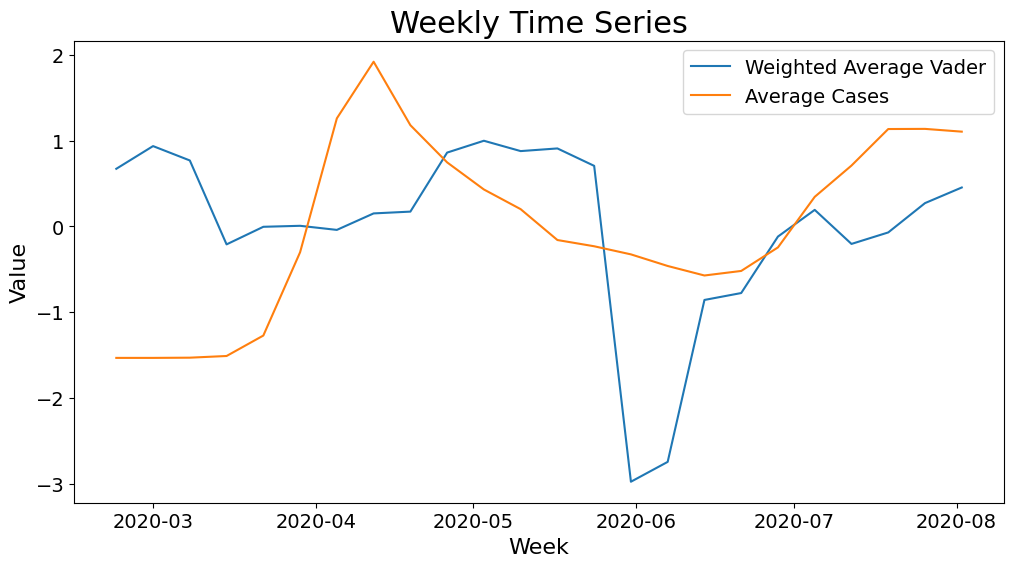

In [14]:
weekly_averages[['WEIGHTED_AVERAGE_VADER','AVERAGE_CASES']] = zscore(weekly_averages[['WEIGHTED_AVERAGE_VADER','AVERAGE_CASES']])
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_averages.index, weekly_averages['WEIGHTED_AVERAGE_VADER'], label='Weighted Average Vader')
ax.plot(weekly_averages.index, weekly_averages['AVERAGE_CASES'], label='Average Cases')
ax.set_xlabel('Week', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Weekly Time Series', fontsize=22)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("trend.png", dpi=300)
plt.show()

# Regression Analysis to compute "trend"

It performs a linear regression analysis to estimate the best-fit line that describes the relationship between
the two variables. The "trend" is the slope of this best-fit line.

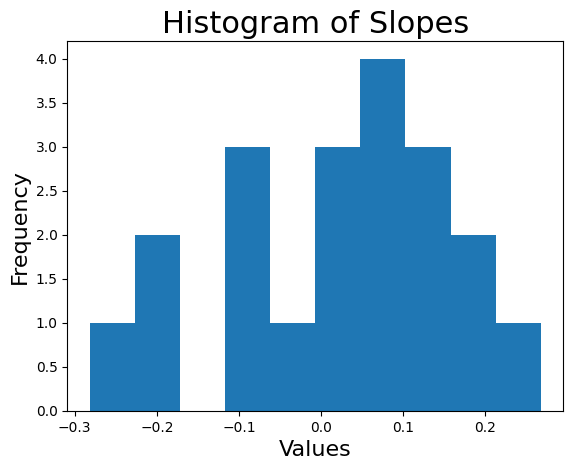

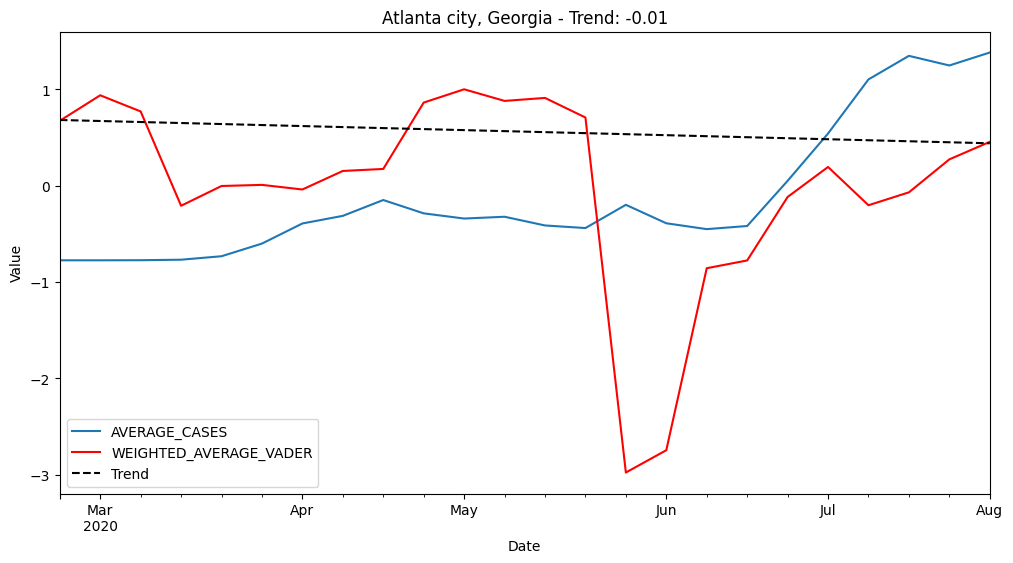

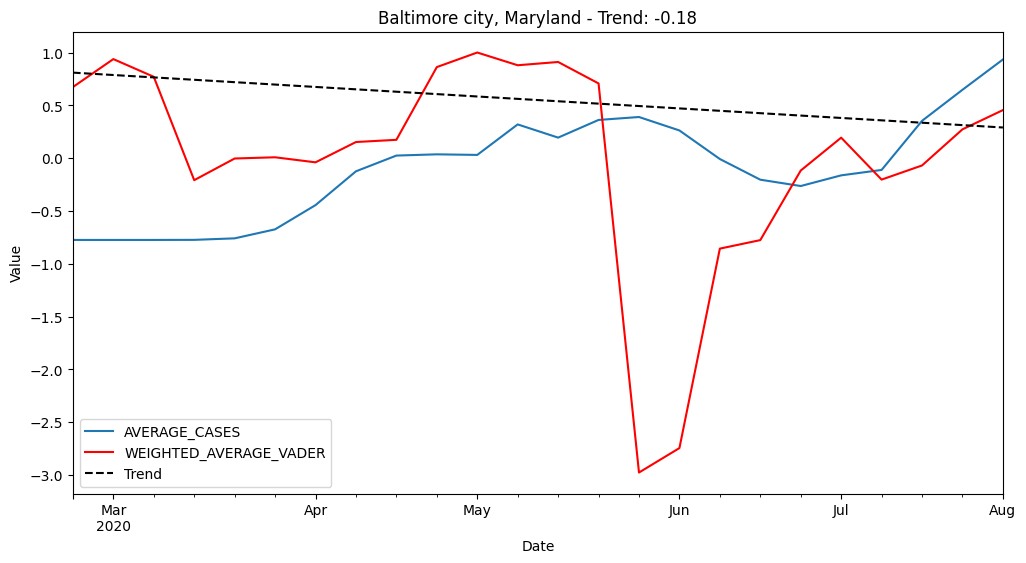

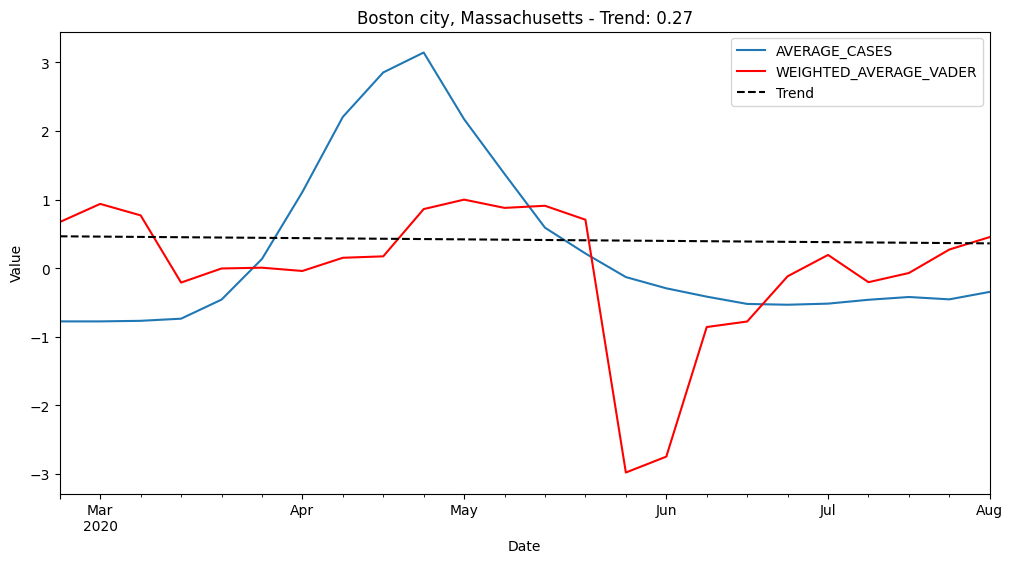

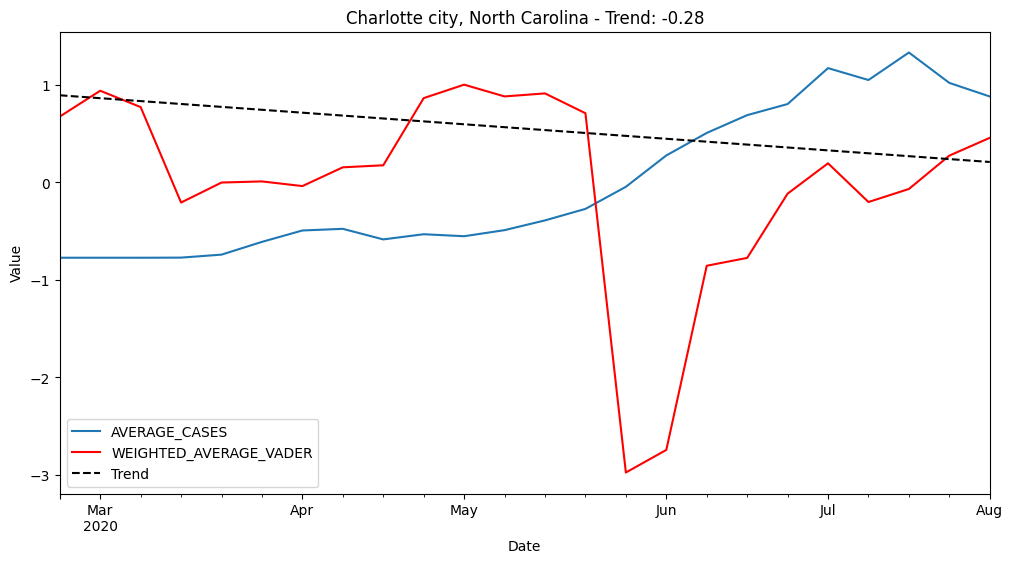

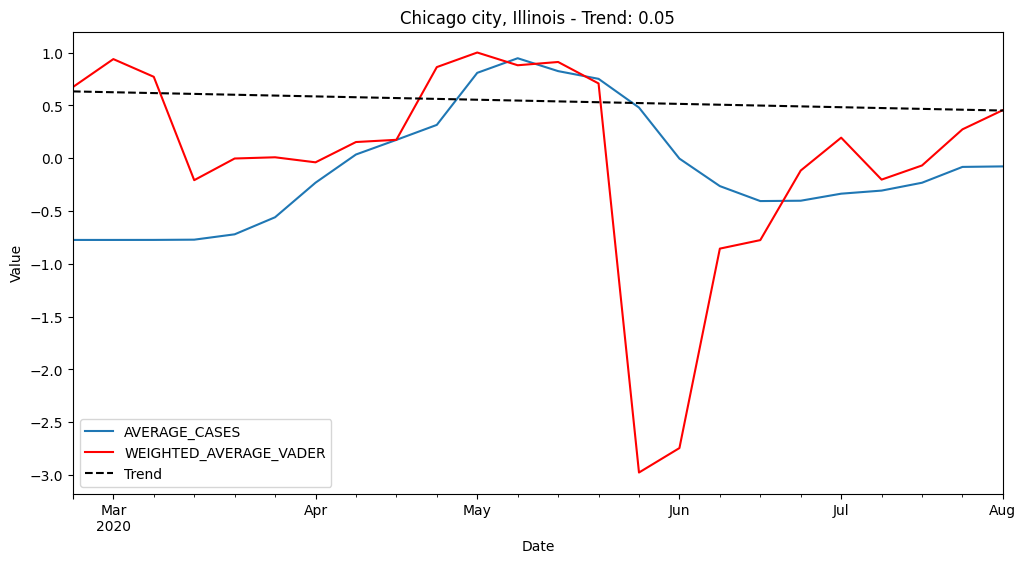

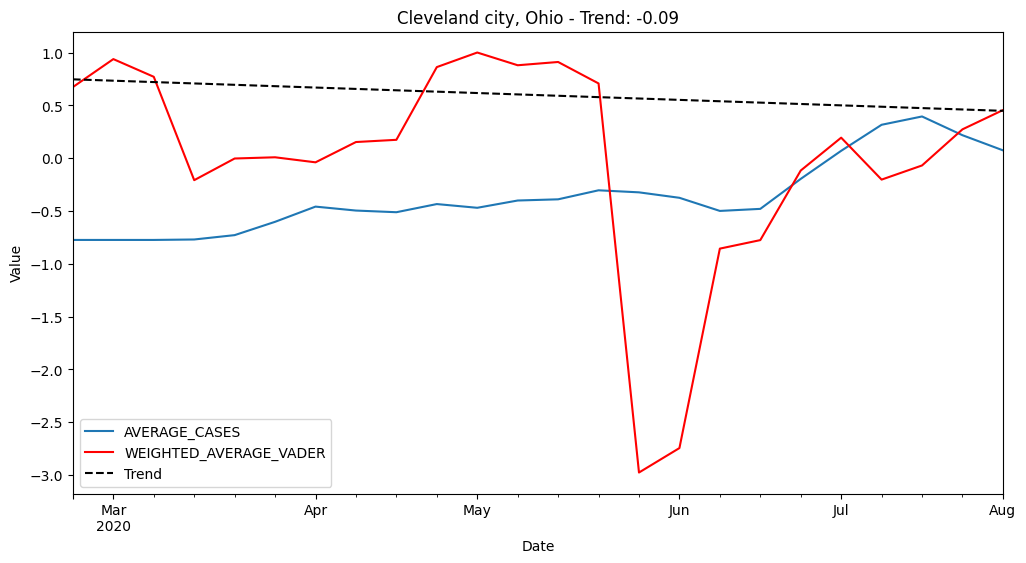

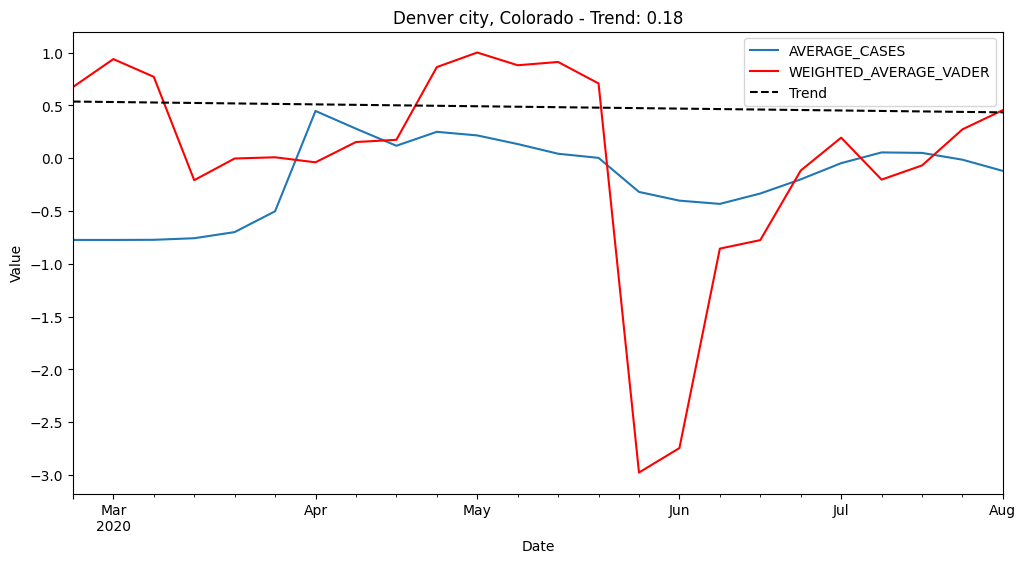

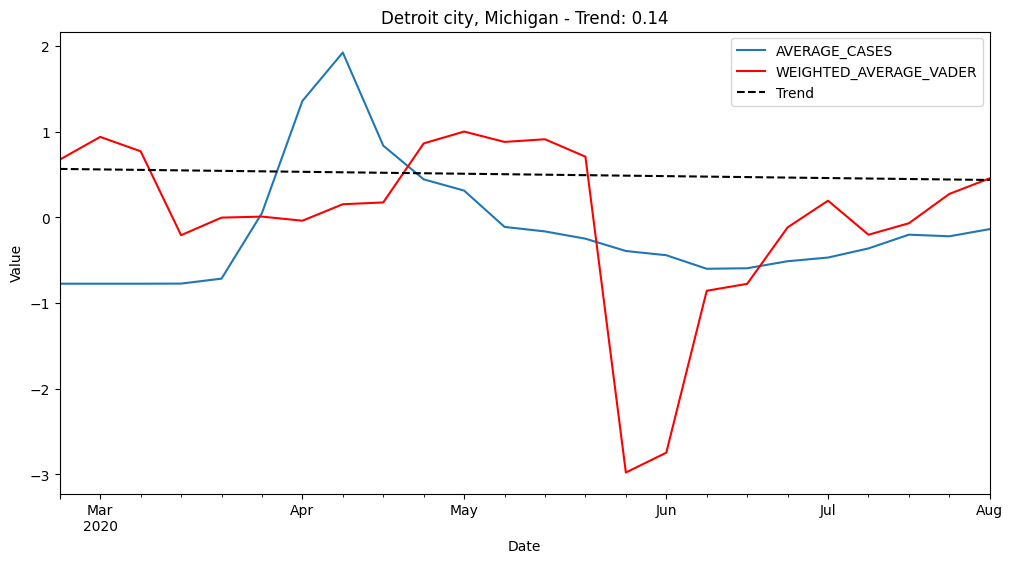

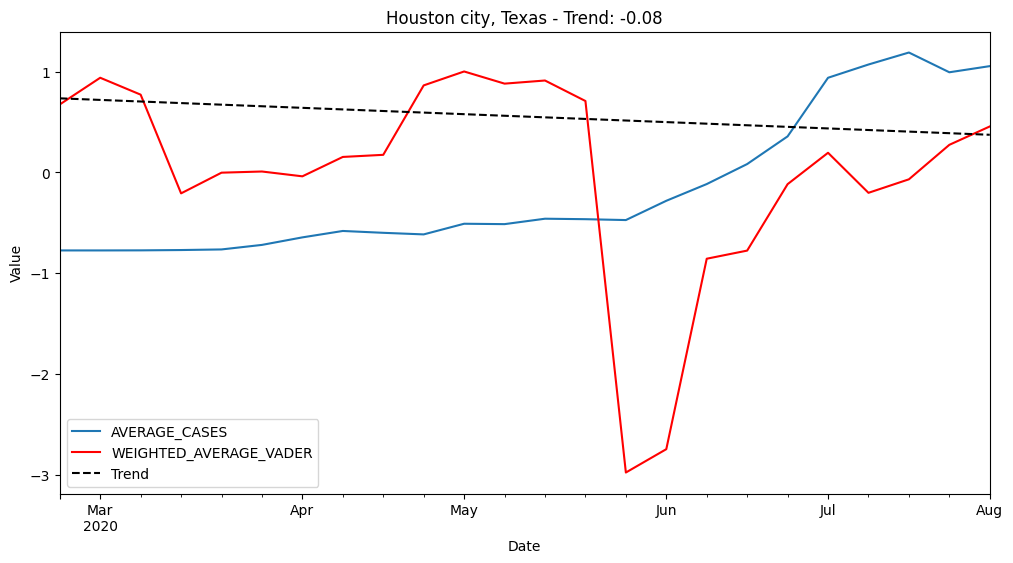

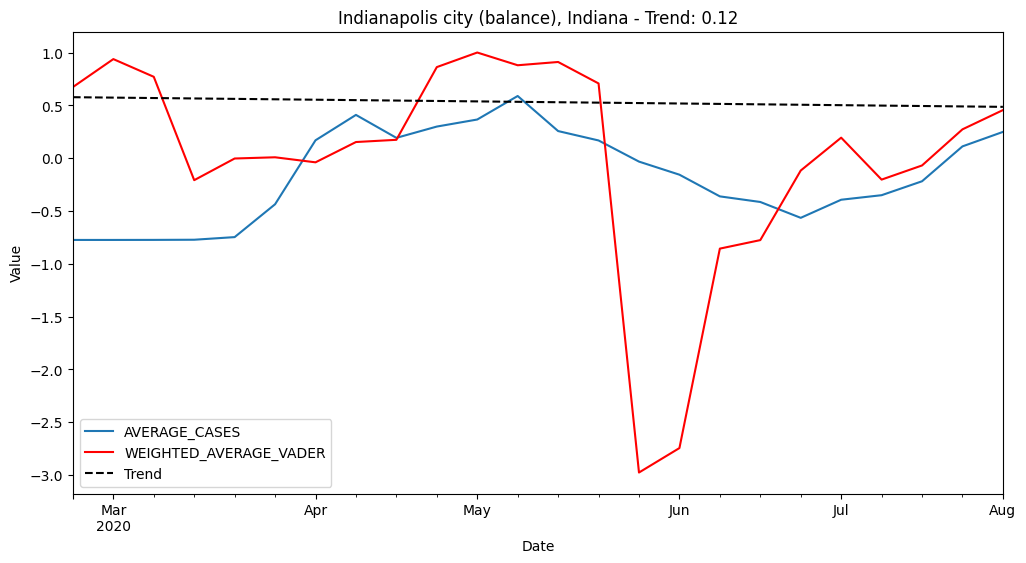

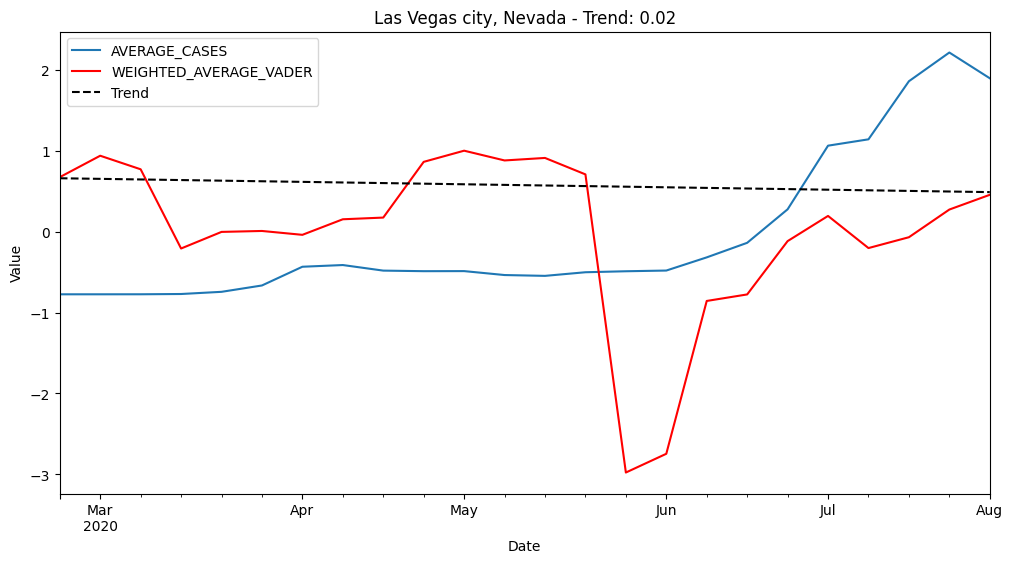

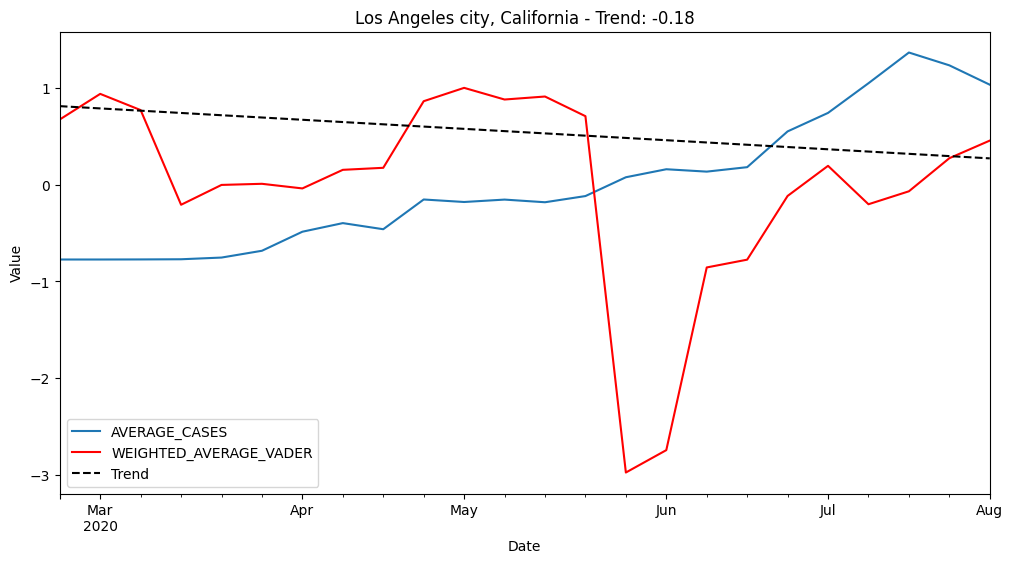

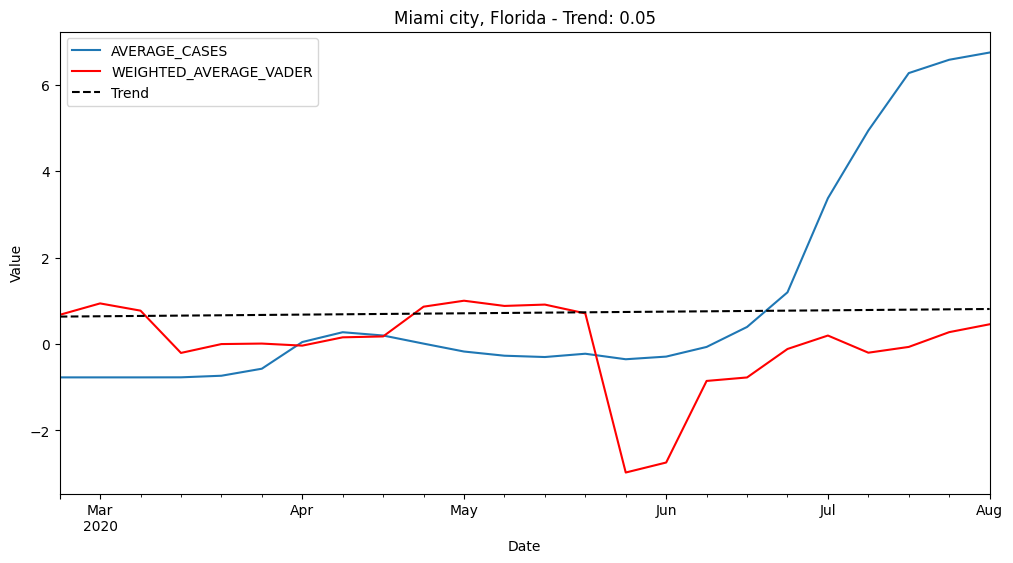

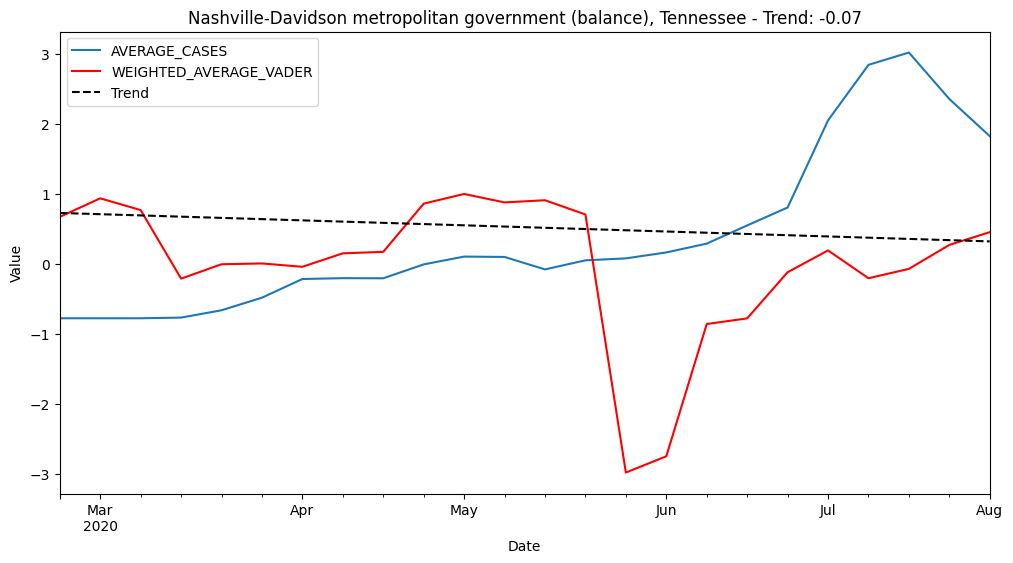

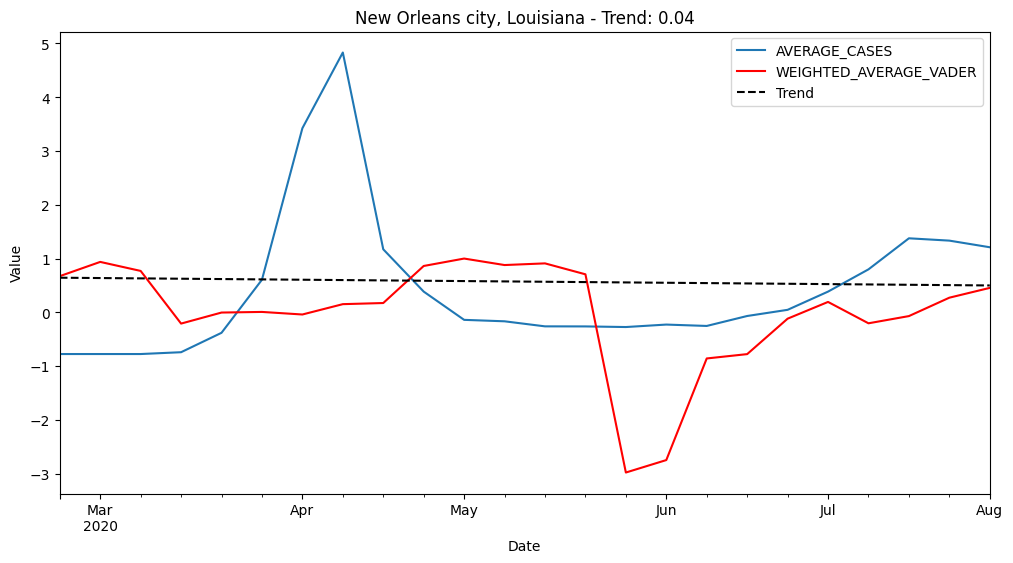

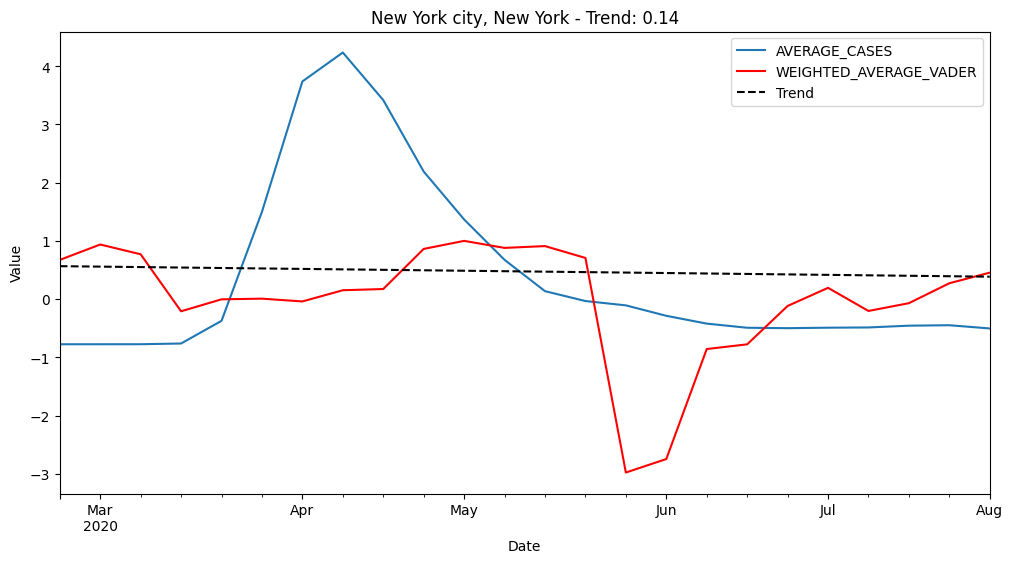

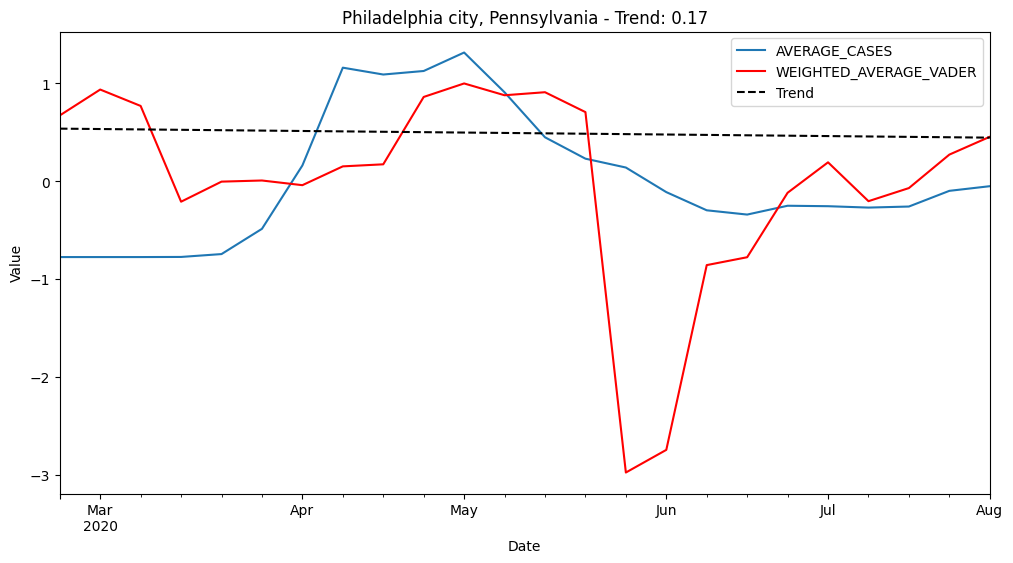

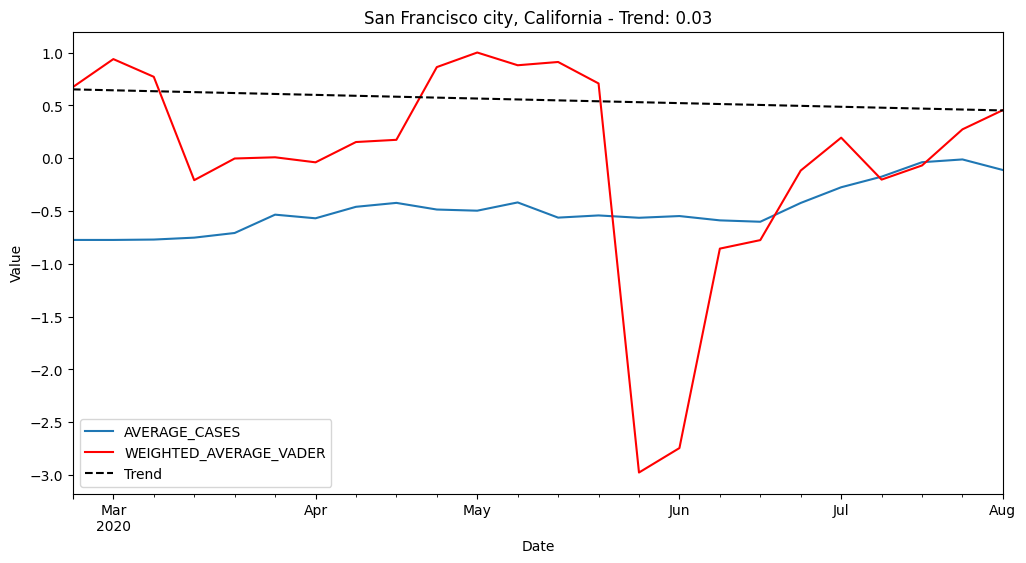

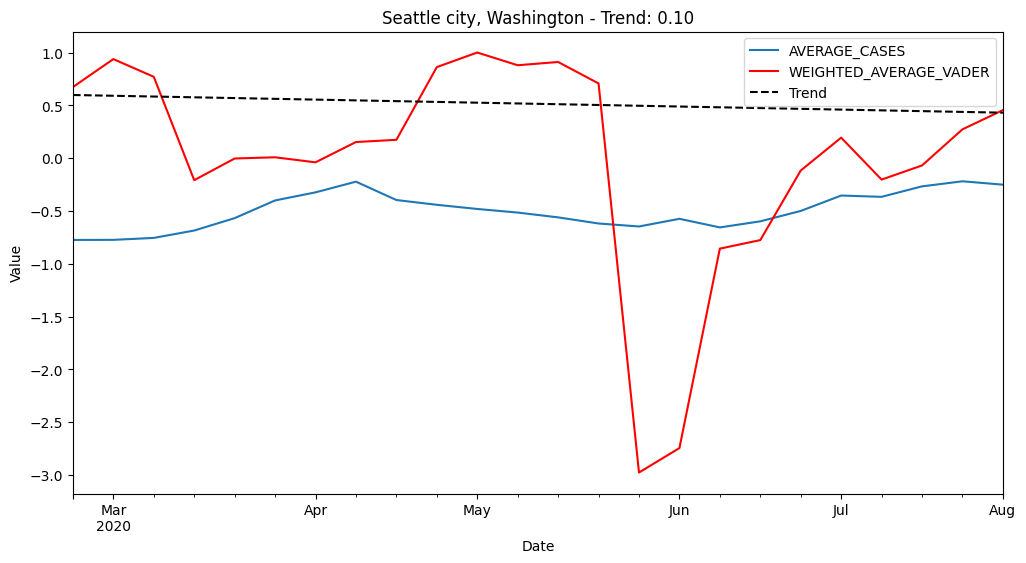

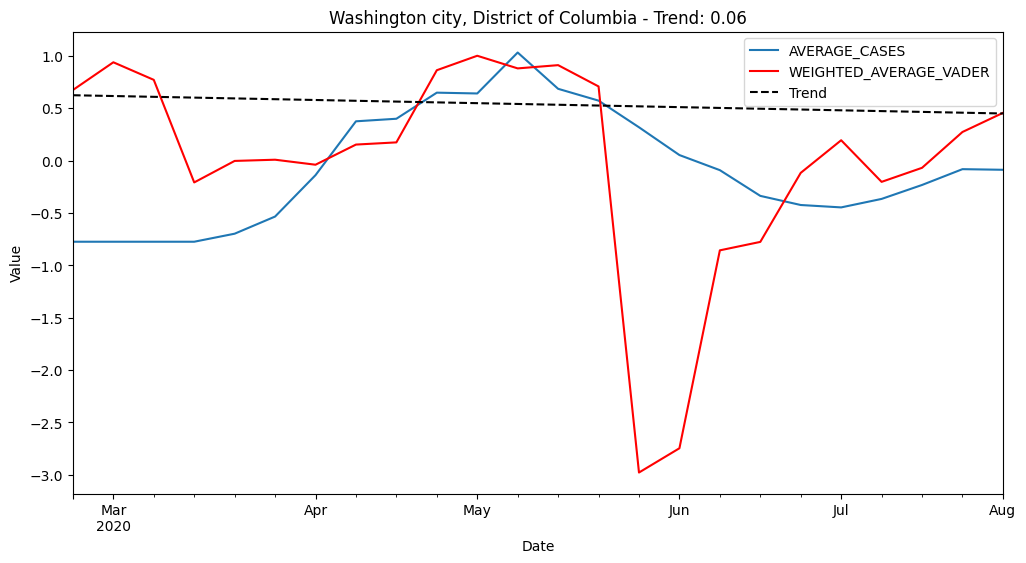

In [15]:
weekly_averages_city[['WEIGHTED_AVERAGE_VADER','AVERAGE_CASES']] = zscore(weekly_averages_city[['WEIGHTED_AVERAGE_VADER','AVERAGE_CASES']])
grouped = weekly_averages_city.groupby('city')

def compute_regression_slope(group):
    slope, intercept, r_value, p_value, std_err = linregress(group['AVERAGE_CASES'], group['WEIGHTED_AVERAGE_VADER'])
    return slope

trends = pd.DataFrame({'trend': grouped.apply(compute_regression_slope)})
trends.reset_index(inplace=True)

### Plot histogram of the trends

In [ ]:
plt.hist(trends['trend'])
plt.xlabel('Values', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Slopes', fontsize=22)
plt.show()

### Plot the time series with the trend line for each city

In [ ]:
for name, group in grouped:
    slope = compute_regression_slope(group)
    fig, ax = plt.subplots(figsize=(12, 6))
    group.plot(x='index', y='AVERAGE_CASES', ax=ax, label='AVERAGE_CASES')
    group.plot(x='index', y='WEIGHTED_AVERAGE_VADER', ax=ax, label='WEIGHTED_AVERAGE_VADER', color='red')
    xmin, xmax = ax.get_xlim()
    x_values = [xmin, xmax]
    y_values = [group['AVERAGE_CASES'].iloc[0] * slope + group['WEIGHTED_AVERAGE_VADER'].iloc[0],
                group['AVERAGE_CASES'].iloc[-1] * slope + group['WEIGHTED_AVERAGE_VADER'].iloc[-1]]
    ax.plot(x_values, y_values, linestyle='--', color='black', label='Trend')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'{name} - Trend: {slope:.2f}')
    ax.legend()
    plt.show()